### Batch Gradient Descent with early stopping for Softmax Regression

In [1]:
# import numpy and the function to load the dataset
import numpy as np
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from math import ceil

In [2]:
# load the data
iris = dict(load_iris())
X = iris["data"]
y = iris["target"]
iris["feature_names"]

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [3]:
# create another variable for the intercept
iris["feature_names"].insert(0, "intercept")
intercept = np.ones((len(y), 1))
X = np.concatenate((intercept, X), axis=1)
X.shape

(150, 5)

In [4]:
# function to split the dataset
def split(X, y, test_ratio, val_ratio, seed = 42):
    '''
    Returns X and y arrays for train, test and 
    validation in that order
    '''
    # get sizes for each set
    n = len(y)
    test_size = int(n * test_ratio)
    val_size = int(n * val_ratio)
    train_size = n - test_size - val_size

    # set random seed
    np.random.seed(seed)

    # select the indices for each set
    indices = np.random.permutation(n)
    train_indices = indices[:train_size]
    test_indices = indices[train_size:-val_size]
    val_indices = indices[-val_size:]

    # returns selected instances
    return (X[train_indices], y[train_indices], 
            X[test_indices], y[test_indices],
            X[val_indices], y[val_indices])

In [5]:
# split the dataset
test_ratio = 0.2
val_ratio = 0.2
X_train, y_train, X_test, y_test, X_val, y_val = \
    split(X, y, test_ratio, val_ratio)

In [6]:
# one hot encode the labels
def one_hot(y):
    '''
    Returns one hot encoded matrix
    '''
    # identity matrix
    identity = np.eye(y.max() + 1)
    
    # select a different row for each class
    return identity[y]

In [7]:
y_train_oh = one_hot(y_train)
y_val_oh = one_hot(y_val)
y_test_oh = one_hot(y_test)

In [8]:
# center and scale the data
# important to use the mean and std from the train set
mean = X_train[:, 1:].mean(axis=0)
std = X_train[:, 1:].std(axis=0)
X_train[:, 1:] = (X_train[:, 1:] - mean) / std
X_val[:, 1:] = (X_val[:, 1:] - mean) / std
X_test[:, 1:] = (X_test[:, 1:] - mean) / std

In [9]:
# define the softmax function
def softmax(linear_comb):
    exps = np.exp(linear_comb)
    sums = exps.sum(axis=1, keepdims=True)
    return exps / sums

In [10]:
n_inputs = X_train.shape[1]  
n_outputs = len(np.unique(y_train))  

In [11]:
# early stopping mini batch

def learning_schedule(t):
    t0, t1 = 200, 1000 
    return t0 / (t + t1)

m = len(X_train)
n_epochs = 50001
minibatch_size = 90
n_batches_per_epoch = ceil(m / minibatch_size)

epsilon = 1e-5
C = 100  # regularization hyperparameter
best_loss = np.infty

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)
losses = []

for epoch in range(n_epochs):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_train[shuffled_indices]
    y_shuffled = y_train_oh[shuffled_indices]

    for iteration in range(n_batches_per_epoch):

        idx = iteration * minibatch_size
        xi = X_b_shuffled[idx : idx + minibatch_size]
        yi = y_shuffled[idx : idx + minibatch_size]
        
        yi_proba = softmax(xi @ Theta)
        yi_proba_valid = softmax(X_val @ Theta)

        xentropy_losses = -(y_val_oh * np.log(yi_proba_valid + epsilon))
        l2_loss = 0.5 * (Theta[1:] ** 2).sum()

        total_loss = xentropy_losses.sum(axis=1).mean() + 1 / C * l2_loss

        losses.append(total_loss)
    
        error = yi_proba - yi
        gradients = 1 / m * xi.T @ error
        gradients += np.r_[np.zeros([1, n_outputs]), 1 / C * Theta[1:]]
        eta = learning_schedule(iteration)
        Theta = Theta - eta * gradients
        
    if epoch % 10000 == 0:
        print(epoch, total_loss)
    mean_loss = np.mean(losses[-100:])
    if mean_loss <= best_loss:
        best_loss = mean_loss
    else:
        print(mean_loss - best_loss, "early stopping!")
        break

0 4.003995705544368
10000 0.2718829714406774
5.551115123125783e-17 early stopping!


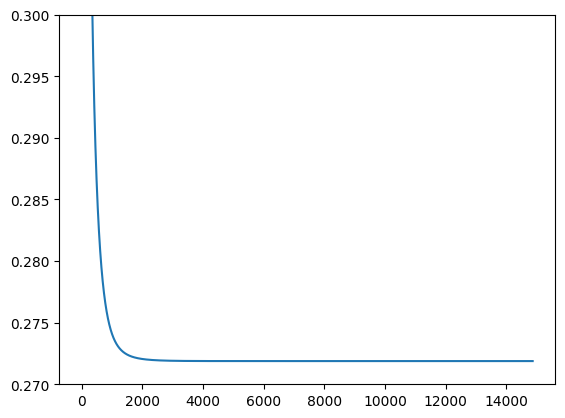

In [12]:
plt.plot(losses);
plt.ylim(0.27,0.3);

In [13]:
logits = X_val @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_val).mean()
accuracy_score

0.9666666666666667

In [14]:
logits = X_test @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_test).mean()
accuracy_score

0.9333333333333333